<h2> Import neccessary packages </h2>

In [1]:
import pandas as pd
import langdetect
from langdetect import detect
from copy import deepcopy
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
import numpy as np

In [131]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import  word_tokenize
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2> Read the data </h2>

In [8]:
data = pd.read_csv('Context.csv')

<h2> Look at the distribution of Target class </h2>

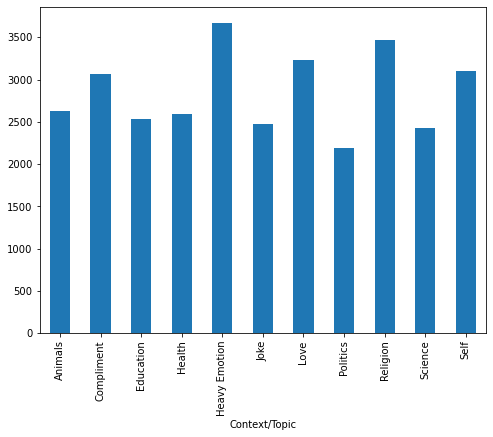

In [11]:

fig = plt.figure(figsize=(8,6))
data.groupby('Context/Topic').Text.count().plot.bar(ylim=0)
plt.show()

In [275]:
df_txt_processing = deepcopy(data)

<h2> Function to detect language of text </h2>

In [276]:

def func_detect(x):
    try:
        return detect(x)
    except:
        pass
df_txt_processing['lang_1'] =  df_txt_processing['Text'].apply(lambda x: func_detect(x))

<h2> Drop rows which are not in english language </h2>

In [277]:

df_txt_processing = df_txt_processing[df_txt_processing['lang_1'] == "en"]

In [278]:
df_txt_processing

,Text,Context/Topic,lang_1
0,The eternal mystique of Goldman Sachs,Politics,en
1,Either you don't care enough to actually tell ...,Love,en
2,I am such an IDIOT.,Heavy Emotion,en
3,While lifting weights on Friday and doing bent...,Health,en
4,Something's watching me,Animals,en
...,...,...,...
31381,**TL;DR**,Heavy Emotion,en
31382,Looks are everything,Heavy Emotion,en
31383,Teacher: write a thing that you want to do til...,Education,en
31384,"General Secretary of India's ruling party, the...",Politics,en


<h2> Text pre-processing </h2>
<h4> Keep Stop words as for 'Self' category accuracy goes down </h4>

In [279]:

#df_txt_processing['Text'] = df_txt_processing['Text'].apply( lambda x: " ".join([i for i in x.lower().split() if i not in stop]) )
df_txt_processing['Text'] = df_txt_processing['Text'].apply( lambda x: " ".join([i for i in x.lower().split()]) )

In [81]:
df_txt_processing

,Text,Context/Topic,lang_1
0,the eternal mystique of goldman sachs,Politics,en
1,either you don't care enough to actually tell ...,Love,en
2,i am such an idiot.,Heavy Emotion,en
3,while lifting weights on friday and doing bent...,Health,en
4,something's watching me,Animals,en
...,...,...,...
31381,**tl;dr**,Heavy Emotion,en
31382,looks are everything,Heavy Emotion,en
31383,teacher: write a thing that you want to do til...,Education,en
31384,"general secretary of india's ruling party, the...",Politics,en


<h2> Perform Lemmatization </h2>

In [189]:

nltk.download('wordnet')
df_txt_processing['Text'] = df_txt_processing['Text'].apply( lambda x: " ".join(lemma.lemmatize(word) for word in x.split()) )


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [137]:
#Punctuation removal
#df_txt_processing['Text'] = df_txt_processing['Text'].apply( lambda x: ''.join(ch for ch in x if ch not in exclude) )

<h2> Label encode the target variable </h2>

In [280]:

df_txt_processing['Context_ID'] = df_txt_processing['Context/Topic'].factorize()[0]

<h2> Transform the words into vectors by leveraging TfidfVectorizer </h2>

In [281]:

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(df_txt_processing.Text).toarray()
labels = df_txt_processing.Context_ID
features.shape

(28021, 22783)

In [282]:
context_ID_df = df_txt_processing[['Context/Topic', 'Context_ID']].drop_duplicates().sort_values('Context_ID')
context_to_ID = dict(context_ID_df.values)
ID_to_context = dict(context_ID_df[['Context_ID', 'Context/Topic']].values)

In [283]:
for topic, context_ID in context_to_ID.items():
    print(topic, context_ID)

Politics 0
Love 1
Heavy Emotion 2
Health 3
Animals 4
Science 5
Joke 6
Religion 7
Self 8
Education 9
Compliment 10


<h2> Look at the common unigrams, bigrams & trigrams </h2>

In [284]:
#Look at the common unigrams, bigrams & trigrams
N = 3
for topic, context_ID in sorted(context_to_ID.items()):
    features_chi2 = chi2(features, labels == context_ID)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(topic))
    print("Most correlated unigrams:\n* {}".format('\n* '.join(unigrams[-N:])))
    print("Most correlated bigrams:\n* {}".format('\n* '.join(bigrams[-N:])))
    print("Most correlated trigrams:\n* {}".format('\n* '.join(trigrams[-N:])))

# 'Animals':
Most correlated unigrams:
* dog
* cat
* animals
Most correlated bigrams:
* animals world
* wild animals
* critter science
Most correlated trigrams:
* male northern white
* northern white rhino
* animals names sounds
# 'Compliment':
Most correlated unigrams:
* congratulations
* proud
* congrats
Most correlated bigrams:
* good luck
* great job
* good job
Most correlated trigrams:
* thank good luck
* thank kind words
* happy cake day
# 'Education':
Most correlated unigrams:
* noida
* education
* school
Most correlated bigrams:
* center noida
* noida sector
* training noida
Most correlated trigrams:
* center noida sector
* training noida sector
* training center noida
# 'Health':
Most correlated unigrams:
* treatment
* covid
* health
Most correlated bigrams:
* health benefits
* weight loss
* covid 19
Most correlated trigrams:
* organic honey dhampurgreen
* tp aigo chargers
* covid 19 pandemic
# 'Heavy Emotion':
Most correlated unigrams:
* fuck
* hate
* fucking
Most correlated 

<h2> Model Selection </h2>

RandomForestClassifier(max_depth=50, n_estimators=500, random_state=0)
LinearSVC()
MultinomialNB()
LogisticRegression(class_weight='balanced', max_iter=10000,
                   multi_class='multinomial', random_state=200)


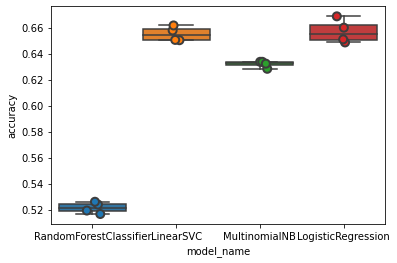

In [287]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import pickle

models = [
    RandomForestClassifier(n_estimators=500, max_depth= 50, random_state=0)
    ,LinearSVC()
    ,MultinomialNB()
    ,LogisticRegression(multi_class='multinomial', random_state = 200, class_weight = 'balanced', max_iter=10000)
]
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    print(model)
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    pickle.dump(model, open('models/'+  model_name + '_final_prediction.pkl', 'wb'))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

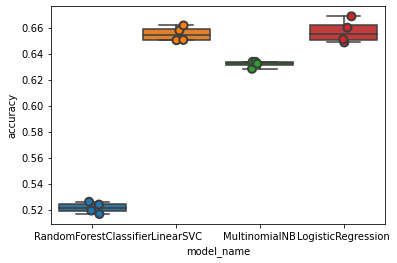

In [288]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

<h1> Based on performance, Logistic Regression is chosen as final model </h1>

In [289]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.655080
LogisticRegression        0.657043
MultinomialNB             0.631990
RandomForestClassifier    0.521466
Name: accuracy, dtype: float64

In [290]:
#import pickle
#pickle.dump(model, open('models/'+  model_name + '_final_prediction.pkl', 'wb'))
del features
import gc
gc.collect()

10844

In [297]:
class TextClassifier(object):
    
    def __init__(self):
        """Simple NLP
        Attributes:
            clf: sklearn classifier model
            vectorizor: TFIDF vectorizer or similar
        """
        self.clf = LogisticRegression(multi_class='multinomial', random_state = 200,class_weight = 'balanced', max_iter=10000)
        
        self.vectorizer = TfidfVectorizer()
        
        #self.vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
        #                stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
        #
        #self.vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
        #                stop_words= 'english',ngram_range=(3,6),dtype=np.float32)
        
    def vectorizer_fit(self, X):
        """Fits a TFIDF vectorizer to the text
        """
        
        self.vectorizer.fit(X)

    def vectorizer_transform(self, X):
        """Transform the text data to a sparse TFIDF matrix
        """
        
        X_transformed = self.vectorizer.transform(X)
        return X_transformed
    

    def train(self, X, y):
        """Trains the classifier to associate the label with the sparse matrix
        """
        # X_train, X_test, y_train, y_test = train_test_split(X, y)
        self.clf.fit(X, y)

    def predict_proba(self, X):
        """Returns probability for the binary class '1' in a numpy array
        """
        y_proba = self.clf.predict_proba(X)
        return y_proba[:, 1]

    def predict(self, X):
        """Returns the predicted class in an array
        """
        y_pred = self.clf.predict(X)
        return y_pred

    def pickle_vectorizer(self, path='C:\\Users\\ankit\\Documents\\Text_Classification\\models\\TFIDFVectorizer.pkl'):
        """Saves the trained vectorizer for future use.
        """
        with open(path, 'wb') as f:
            pickle.dump(self.vectorizer, f)
            print("Pickled vectorizer at {}".format(path))

    def pickle_clf(self, path = 'C:\\Users\\ankit\\Documents\\Text_Classification\\models\\LogisticRegression_final_prediction.pkl'):
        """Saves the trained classifier for future use.
        """
        with open(path, 'wb') as f:
            pickle.dump(self.clf, f)
            print("Pickled classifier at {}".format(path))


In [298]:
model = TextClassifier()

In [299]:
train=df_txt_processing.sample(frac=0.8, random_state=200) #random state is a seed value
test=df_txt_processing.drop(train.index)

In [300]:
model.vectorizer_fit(train['Text'])
print('Vectorizer fit complete')
X = model.vectorizer_transform(train['Text'])
print('Vectorizer transform complete')
y = train['Context/Topic']

model.train(X, y)
model.pickle_clf()
model.pickle_vectorizer()

Vectorizer fit complete
Vectorizer transform complete
Pickled classifier at C:\Users\ankit\Documents\Text_Classification\models\LogisticRegression_final_prediction.pkl
Pickled vectorizer at C:\Users\ankit\Documents\Text_Classification\models\TFIDFVectorizer.pkl


In [301]:
trn=df_txt_processing['Text'].sample(frac=0.8,random_state=200) #random state is a seed value
test=df_txt_processing['Text'].drop(trn.index)

In [231]:
#user_query = np.array(['Animals are kind'])
#model.vectorizer_fit(user_query)
#uq_vectorized = model.vectorizer_transform(user_query)

In [232]:
import pickle
clf_path = 'C:\\Users\\ankit\\Documents\\Text_Classification\\models\\LogisticRegression_final_prediction.pkl'
with open(clf_path, 'rb') as f:
    model.clf = pickle.load(f)

In [234]:
vec_path = 'C:\\Users\\ankit\\Documents\\Text_Classification\\models\\TFIDFVectorizer.pkl'
with open(vec_path, 'rb') as f:
    model.vectorizer = pickle.load(f)

In [352]:
x = '''Be kind to all animals'''
uq_vectorized = model.vectorizer_transform(np.array([x]))
prediction = model.predict(uq_vectorized)
pred_proba = model.predict_proba(uq_vectorized)
print(prediction)

['Animals']
